In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from intent_classification_helper import *

In [ ]:
atis_train = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/atis_intents_train.csv', error_bad_lines=False, 
                   engine='python', encoding='utf-8', names=['intent', 'message'])
atis_test = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/atis_intents_test.csv', error_bad_lines=False, 
                   engine='python', encoding='utf-8', names=['intent', 'message'])
assert(set(atis_train['intent']) == set(atis_test['intent']))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
atis_train['intent'].value_counts()

atis_flight            3666
atis_airfare            423
atis_ground_service     255
atis_airline            157
atis_abbreviation       147
atis_aircraft            81
atis_flight_time         54
atis_quantity            51
Name: intent, dtype: int64

In [ ]:
atis_train = balance_class(atis_train, 'message', 'intent')

In [ ]:
atis_train['intent'].value_counts()

atis_flight            3666
atis_flight_time       3666
atis_airfare           3666
atis_aircraft          3666
atis_ground_service    3666
atis_airline           3666
atis_abbreviation      3666
atis_quantity          3666
Name: intent, dtype: int64

In [ ]:
# encode label
le = LabelEncoder()
atis_train['intent'] = le.fit_transform(atis_train['intent'])
atis_test['intent'] = le.fit_transform(atis_test['intent'])

onehot_encoder = OneHotEncoder()
y_train = onehot_encoder.fit_transform(atis_train['intent'].values.reshape(-1, 1)).todense()
y_test = onehot_encoder.fit_transform(atis_test['intent'].values.reshape(-1, 1)).todense()

In [ ]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])

array(['atis_abbreviation', 'atis_aircraft', 'atis_airfare',
       'atis_airline', 'atis_flight', 'atis_flight_time',
       'atis_ground_service', 'atis_quantity'], dtype=object)

In [ ]:
# preprocess text
print('Preprocessing text on training set...')
preprocess_text(atis_train, 'message')

print('Preprocessing text on test set...')
preprocess_text(atis_test, 'message')

Preprocessing text on training set...


Start text preprocessing: 
--------------------------
Converting to lowercase...
--------------------------
Removing html tags...
--------------------------
Removing nonword characters...
--------------------------
Removing stopwords...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Text preprocessing completed.


Preprocessing text on test set...


Start text preprocessing: 
--------------------------
Converting to lowercase...
--------------------------
Removing html tags...
--------------------------
Removing nonword characters...
--------------------------
Removing stopwords...
Text preprocessing completed.




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# added this part: tf-idf features vs feature frequence in each record
from sklearn.feature_extraction.text import TfidfVectorizer
import os

feature_numbers=[40, 100, 200, 500, 1000]

for feature_number in feature_numbers:  
    tv = TfidfVectorizer(max_df=1.0, min_df=0, max_features=feature_number)
    
    x_train = atis_train['message'].tolist()
    x_test = atis_test['message'].tolist()

    tv.fit(x_train)
    x_train = tv.transform(x_train).toarray()
    x_test = tv.transform(x_test).toarray()

    vocab = tv.get_feature_names_out()

    print('TF-IDF vocabulary size: ', len(vocab))

    x_train_freq_df = pd.DataFrame(x_train, columns=vocab)
    x_test_freq_df = pd.DataFrame(x_test, columns=vocab)
    
    main_path = '/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency'
    x_train_file_name = 'train_tf-idf_feature_{}.csv'.format(len(vocab))
    x_test_file_name = 'test_tf-idf_feature_{}.csv'.format(len(vocab))

    x_train_freq_df.to_csv(os.path.join(main_path, x_train_file_name), index=False)
    x_test_freq_df.to_csv(os.path.join(main_path, x_test_file_name), index=False)

TF-IDF vocabulary size:  40
TF-IDF vocabulary size:  100
TF-IDF vocabulary size:  200
TF-IDF vocabulary size:  500
TF-IDF vocabulary size:  748


In [ ]:
# add label column
df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/train_tf-idf_feature_40.csv')
df['label'] = atis_train['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/train_tf-idf_feature_40.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/test_tf-idf_feature_40.csv')
df['label'] = atis_test['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/test_tf-idf_feature_40.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def rf_tf_idf(feature_numbers=[40, 100, 200, 500, 1000]):
  
  # try different number of features
  for feature_number in feature_numbers:  
    tv = TfidfVectorizer(max_df=1.0, min_df=0, max_features=feature_number)
    
    x_train = atis_train['message'].tolist()
    x_test = atis_test['message'].tolist()

    tv.fit(x_train)
    x_train = tv.transform(x_train).toarray()
    x_test = tv.transform(x_test).toarray()

    vocab = tv.get_feature_names_out()

    print('TF-IDF vocabulary size: ', len(vocab))
    #print(pd.DataFrame(x_train, columns=vocab))
    
    model = random_foreset_classifier(x_train=x_train, y_train=y_train, num_features=len(vocab), n_estimators=150, max_depth=None, saving=False)
    evaluate_model(model=model, name='random_forest_{}_features_n_estimators=150_max_depth=None'.format(len(vocab)), x_test=x_test, y_test=y_test, num_features=len(vocab),
                   path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_updated.csv')

    print()
    if feature_number < len(vocab):
      break

In [ ]:
rf_tf_idf()

TF-IDF vocabulary size:  40


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_40_features_n_estimators=150_max_depth=None
accuracy score:  0.895
balanced accuracy score:  0.9267155229846769
weighted precision:  0.9310974852612177
weighted recall:  0.895
weighted f1 score:  0.9060103046637167
macro f1 score:  0.794132631444443

TF-IDF vocabulary size:  100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_100_features_n_estimators=150_max_depth=None
accuracy score:  0.92875
balanced accuracy score:  0.9387572636760678
weighted precision:  0.9474932681520727
weighted recall:  0.92875
weighted f1 score:  0.9337689602400673
macro f1 score:  0.8323397911993433



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  200


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_200_features_n_estimators=150_max_depth=None
accuracy score:  0.95625
balanced accuracy score:  0.9460631569694278
weighted precision:  0.9651869903556374
weighted recall:  0.95625
weighted f1 score:  0.9582971074858955
macro f1 score:  0.871049520166786



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  500


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_500_features_n_estimators=150_max_depth=None
accuracy score:  0.96
balanced accuracy score:  0.873679121326523
weighted precision:  0.9679373435219415
weighted recall:  0.96
weighted f1 score:  0.9622732287582284
macro f1 score:  0.836223313504497



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




TF-IDF vocabulary size:  748


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_748_features_n_estimators=150_max_depth=None
accuracy score:  0.955
balanced accuracy score:  0.9431085294988526
weighted precision:  0.9661593786295006
weighted recall:  0.955
weighted f1 score:  0.9579487406858952
macro f1 score:  0.8636230305898366



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_graph(model_name, eval_path, reverse_rows=False):
  # plot the feature importance graph for random forest
  plt.title('Performance of {} vs Feature Numbers'.format(model_name))
  plt.xlabel('Number of Features')
  plt.ylabel('Score')

  eval_result = pd.read_csv(eval_path, error_bad_lines=False, engine='python', encoding='utf-8')
  if reverse_rows:
    eval_result = eval_result.loc[::-1]

  feature_numbers = eval_result['num_features'].to_list()
  accuracy_scores = eval_result['accuracy score'].to_list()
  balanced_accuracy_scores = eval_result['balanced accuracy score'].to_list()
  weighted_precision = eval_result['weighted precision'].to_list()
  weighted_recall = eval_result['weighted recall'].to_list()
  weighted_f1_scores = eval_result['weighted f1 score'].to_list()
  macro_f1_scores = eval_result['macro f1 score'].to_list()

  plt.plot(feature_numbers, accuracy_scores, label='accuracy score')
  plt.plot(feature_numbers, weighted_precision, label='weighted precision')
  plt.plot(feature_numbers, weighted_recall, label='weighted recall')
  plt.plot(feature_numbers, weighted_f1_scores, label='weighted f1 score')
  plt.legend()
  plt.grid()

  plt.figure()
  plt.xlabel('Number of Features')
  plt.ylabel('Score')
  plt.plot(feature_numbers, balanced_accuracy_scores, label='balanced accuracy score')
  plt.plot(feature_numbers, macro_f1_scores, label='macro f1 score')

  plt.legend()
  plt.grid()
  plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


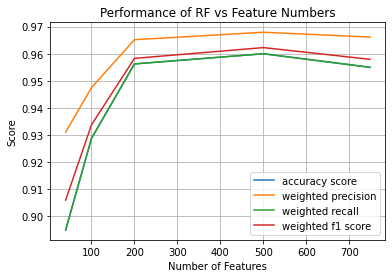

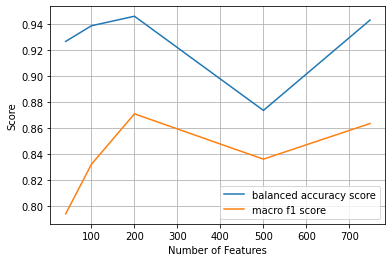

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# plot the feature importance graph for random forest
plt.title('Performance of RF vs Feature Numbers')
plt.xlabel('Number of Features')
plt.ylabel('Score')

eval_path = '/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_updated.csv'
eval_result = pd.read_csv(eval_path, error_bad_lines=False, engine='python', encoding='utf-8')

feature_numbers = eval_result['num_features'].to_list()
accuracy_scores = eval_result['accuracy score'].to_list()
balanced_accuracy_scores = eval_result['balanced accuracy score'].to_list()
weighted_precision = eval_result['weighted precision'].to_list()
weighted_recall = eval_result['weighted recall'].to_list()
weighted_f1_scores = eval_result['weighted f1 score'].to_list()
macro_f1_scores = eval_result['macro f1 score'].to_list()

plt.plot(feature_numbers, accuracy_scores, label='accuracy score')
plt.plot(feature_numbers, weighted_precision, label='weighted precision')
plt.plot(feature_numbers, weighted_recall, label='weighted recall')
plt.plot(feature_numbers, weighted_f1_scores, label='weighted f1 score')
plt.legend()
plt.grid()

plt.figure()
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.plot(feature_numbers, balanced_accuracy_scores, label='balanced accuracy score')
plt.plot(feature_numbers, macro_f1_scores, label='macro f1 score')

plt.legend()
plt.grid()
plt.show()

In [ ]:
atis_train['message'].head()

0       want fly boston 838 arrive denver 1110 morning
1    flights available pittsburgh baltimore thursda...
2    arrival time san francisco 755 flight leaving ...
3                      cheapest airfare tacoma orlando
4    round trip fares pittsburgh philadelphia 1000 ...
Name: message, dtype: object

In [ ]:
# word2vec
sents_train = []

for row in atis_train['message'].tolist():
  sents_train.append(row.split())
  
sents_test = []

for row in atis_test['message'].tolist():
  sents_test.append(row.split())

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import Word2Vec

In [ ]:
import copy

for num_features in [40]:
#for num_features in [40, 100, 200, 500, 1000]:
  model_w2v = Word2Vec(sents_train, max_final_vocab=num_features)

  x_train_freq_df = pd.DataFrame(columns = model_w2v.wv.vocab.keys())
  x_test_freq_df = pd.DataFrame(columns = model_w2v.wv.vocab.keys())

  print('number of features: ', len(model_w2v.wv.vocab))

  freq_dic = {}
  for word in model_w2v.wv.vocab.keys():
    freq_dic[word] = 0

  for i in range(len(sents_train)):
    temp_freq_dic = copy.deepcopy(freq_dic)
    sent = sents_train[i]      
    for w in sent:
      if w in model_w2v.wv.vocab.keys():
        temp_freq_dic[w] += 1

    x_train_freq_df = x_train_freq_df.append(temp_freq_dic, ignore_index=True)
  
  for i in range(len(sents_test)):
    temp_freq_dic = copy.deepcopy(freq_dic)
    sent = sents_test[i]      
    for w in sent:
      if w in model_w2v.wv.vocab.keys():
        temp_freq_dic[w] += 1

    x_test_freq_df = x_test_freq_df.append(temp_freq_dic, ignore_index=True)

  main_path = '/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/word2vec'
  x_train_file_name = 'train_word2vec_feature_{}.csv'.format(len(model_w2v.wv.vocab))
  x_test_file_name = 'test_word2vec_feature_{}.csv'.format(len(model_w2v.wv.vocab))

  x_train_freq_df.to_csv(os.path.join(main_path, x_train_file_name), index=False)
  x_test_freq_df.to_csv(os.path.join(main_path, x_test_file_name), index=False)

number of features:  40


In [ ]:
# add label column
df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/word2vec/train_word2vec_feature_40.csv')
df['label'] = atis_train['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/word2vec/train_word2vec_feature_40.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/word2vec/test_word2vec_feature_40.csv')
df['label'] = atis_test['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/word2vec/test_word2vec_feature_40.csv', index=False)

In [ ]:
def w2v_rf():
  # chaneg min_count parameter to control different number of features
  #for limit in range(1, 11): 
  #for limit in range(12, 31):
  #for limit in range(32, 51):
  for num in [40, 100, 200, 500, 1000]:
    #model_w2v = Word2Vec(sents_train, min_count=limit)
    model_w2v = Word2Vec(sents_train, max_final_vocab=num)
    model_w2v.train(sents_train, total_examples=model_w2v.corpus_count, epochs=30)
    num_features = len(model_w2v.wv.vocab)

    w2v_ebd_len = model_w2v.wv['time'].shape[0]
    x_train_w2v = np.zeros([len(atis_train['message']), w2v_ebd_len]) # initialize to zero, save zero padding
    x_test_w2v = np.zeros([len(atis_test['message']), w2v_ebd_len])

    # build x_train_w2v with averaged word embedding
    for i in range(len(sents_train)):
      sent = sents_train[i]
      if sent == []: # handle the case with division, if it is empty sent, set to zero
        continue 
      word_count = 0
      for j in range(len(sent)):
        word = sent[j]
        if word not in model_w2v.wv:
          continue
        word_count += 1
        x_train_w2v[i] = np.add(x_train_w2v[i], model_w2v.wv[word])
      if word_count > 0:
        x_train_w2v[i] = np.divide(x_train_w2v[i], word_count)
    
    y_train_w2v = y_train

    # build x_test_w2v with averaged word embedding
    for i in range(len(sents_test)):
      sent = sents_test[i]
      if sent == []: 
        continue 
      word_count = 0
      for j in range(len(sent)):
        word = sent[j]
        if word not in model_w2v.wv:
          continue
        word_count += 1
        x_test_w2v[i] = np.add(x_test_w2v[i], model_w2v.wv[word])
      if word_count > 0:
        x_test_w2v[i] = np.divide(x_test_w2v[i], word_count)

      y_test_w2v = y_test

    model_rf_w2v = RandomForestClassifier(n_estimators=150, max_depth=None)
    model_rf_w2v.fit(x_train_w2v, y_train_w2v)

    evaluate_model(model=model_rf_w2v, name='random_forest_w2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_test_w2v, y_test=y_test_w2v, num_features=num_features,
                   path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_w2v_updated.csv')

In [ ]:
w2v_rf()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_w2v_features_40_n_estimators=150_max_depth=None
accuracy score:  0.885
balanced accuracy score:  0.8041057119327856
weighted precision:  0.9222573806190121
weighted recall:  0.885
weighted f1 score:  0.8971027563052502
macro f1 score:  0.735820560971272


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_w2v_features_100_n_estimators=150_max_depth=None
accuracy score:  0.895
balanced accuracy score:  0.5766988674217188
weighted precision:  0.9051975741652794
weighted recall:  0.895
weighted f1 score:  0.8931108034293774
macro f1 score:  0.5864798510169489


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_w2v_features_199_n_estimators=150_max_depth=None
accuracy score:  0.90375
balanced accuracy score:  0.48396555074394854
weighted precision:  0.9131247944078947
weighted recall:  0.90375
weighted f1 score:  0.8925177790079485
macro f1 score:  0.5077724832080647


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_w2v_features_496_n_estimators=150_max_depth=None
accuracy score:  0.91625
balanced accuracy score:  0.5174993291509364
weighted precision:  0.9197010518436811
weighted recall:  0.91625
weighted f1 score:  0.9053770881171067
macro f1 score:  0.5461972588978187


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_w2v_features_516_n_estimators=150_max_depth=None
accuracy score:  0.91375
balanced accuracy score:  0.5122909958176031
weighted precision:  0.9152702997989687
weighted recall:  0.91375
weighted f1 score:  0.9011929003707021
macro f1 score:  0.5483933391799771


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


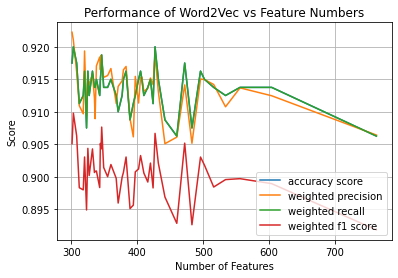

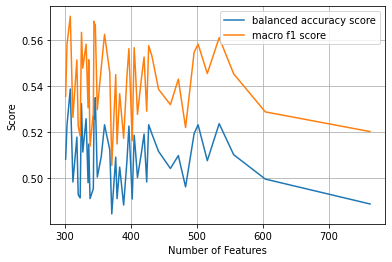

In [ ]:
eval_path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_w2v.csv'
plot_feature_graph(model_name='Word2Vec', eval_path=eval_path, reverse_rows=True)

In [ ]:
#Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sents_train)]

In [ ]:
model_d2v = Doc2Vec(documents, min_count=1, epochs=30)

In [ ]:
len(model_d2v.wv.vocab)

763

In [ ]:
model_d2v.wv.vectors.shape

(763, 100)

In [ ]:
model_d2v.corpus_count

29328

In [ ]:
model_d2v.train(documents, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [ ]:
len(model_d2v.wv.vocab)

763

In [ ]:
model_d2v.infer_vector(sents_train[0]).shape[0]

(100,)

In [ ]:
for num_features in [91]:
#for num_features in [40, 100, 200, 500, 1000]:
  model_d2v = Doc2Vec(documents, max_vocab_size=num_features)

  x_train_freq_df = pd.DataFrame(columns = model_d2v.wv.vocab.keys())
  x_test_freq_df = pd.DataFrame(columns = model_d2v.wv.vocab.keys())

  print('number of features: ', len(model_d2v.wv.vocab))

  freq_dic = {}
  for word in model_d2v.wv.vocab.keys():
    freq_dic[word] = 0

  for i in range(len(sents_train)):
    temp_freq_dic = copy.deepcopy(freq_dic)
    sent = sents_train[i]      
    for w in sent:
      if w in model_d2v.wv.vocab.keys():
        temp_freq_dic[w] += 1

    x_train_freq_df = x_train_freq_df.append(temp_freq_dic, ignore_index=True)
  
  for i in range(len(sents_test)):
    temp_freq_dic = copy.deepcopy(freq_dic)
    sent = sents_test[i]      
    for w in sent:
      if w in model_d2v.wv.vocab.keys():
        temp_freq_dic[w] += 1

    x_test_freq_df = x_test_freq_df.append(temp_freq_dic, ignore_index=True)

  main_path = '/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/doc2vec'
  x_train_file_name = 'train_doc2vec_feature_{}.csv'.format(len(model_d2v.wv.vocab))
  x_test_file_name = 'test_doc2vec_feature_{}.csv'.format(len(model_d2v.wv.vocab))

  x_train_freq_df.to_csv(os.path.join(main_path, x_train_file_name), index=False)
  x_test_freq_df.to_csv(os.path.join(main_path, x_test_file_name), index=False)

number of features:  50


In [ ]:
# add label column
df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/doc2vec/train_doc2vec_feature_50.csv')
df['label'] = atis_train['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/doc2vec/train_doc2vec_feature_50.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/doc2vec/test_doc2vec_feature_50.csv')
df['label'] = atis_test['intent']
df.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/feature_frequency/doc2vec/test_doc2vec_feature_50.csv', index=False)

In [ ]:
def d2v_rf():
  # change min_count parameter to control different number of features
  for num_features in [91]:
  # for limit in range(1, 51):
    #model_d2v = Doc2Vec(documents, min_count=limit, epochs=30)
    model_d2v = Doc2Vec(documents, max_vocab_size=num_features, epochs=30)
    model_d2v.train(documents, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
    num_features = len(model_d2v.wv.vocab)

    d2v_ebd_len = model_d2v.infer_vector(sents_train[0]).shape[0]
    x_train_d2v = np.zeros([len(atis_train['message']), d2v_ebd_len]) # initialize to zero, save zero padding
    x_test_d2v = np.zeros([len(atis_test['message']), d2v_ebd_len])

    for i in range(len(sents_train)):
      sent = sents_train[i]
      x_train_d2v[i] = model_d2v.infer_vector(sent)
    
    y_train_d2v = y_train

    for i in range(len(sents_test)):
      sent = sents_test[i]
      x_test_d2v[i] = model_d2v.infer_vector(sent)

    y_test_d2v = y_test

    model_rf_d2v = RandomForestClassifier(n_estimators=150, max_depth=None)
    model_rf_d2v.fit(x_train_d2v, y_train_d2v)

    evaluate_model(model=model_rf_d2v, name='random_forest_d2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_test_d2v, y_test=y_test_d2v, num_features=num_features,
                   path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_d2v.csv')

In [ ]:
d2v_rf()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_d2v_features_50_n_estimators=150_max_depth=None
accuracy score:  0.355
balanced accuracy score:  0.46236247594196456
weighted precision:  0.886112716730198
weighted recall:  0.355
weighted f1 score:  0.45406715053827534
macro f1 score:  0.3067556064798569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.




In [ ]:
# combine evaluation result of 40 features (d2v is 50) into a single csv

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_updated.csv')
df2 = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_d2v.csv')
df3 = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_w2v_updated.csv')

In [ ]:
df1.iloc[0]

model                      random_forest_40_features_n_estimators=150_max...
accuracy score                                                         0.895
balanced accuracy score                                             0.926716
weighted precision                                                  0.931097
weighted recall                                                        0.895
weighted f1 score                                                    0.90601
macro f1 score                                                      0.794133
num_features                                                              40
Name: 0, dtype: object

In [ ]:
df2.iloc[-1]

model                      random_forest_d2v_features_50_n_estimators=150...
accuracy score                                                         0.355
balanced accuracy score                                             0.462362
weighted precision                                                  0.886113
weighted recall                                                        0.355
weighted f1 score                                                   0.454067
macro f1 score                                                      0.306756
num_features                                                              50
Name: 18, dtype: object

In [ ]:
df3.iloc[0]

model                      random_forest_w2v_features_40_n_estimators=150...
accuracy score                                                         0.885
balanced accuracy score                                             0.804106
weighted precision                                                  0.922257
weighted recall                                                        0.885
weighted f1 score                                                   0.897103
macro f1 score                                                      0.735821
num_features                                                              40
Name: 0, dtype: object

In [ ]:
df_comb = pd.DataFrame(columns = df1.columns)

In [ ]:
df_comb = df_comb.append(df1.iloc[0])
df_comb = df_comb.append(df3.iloc[0])
df_comb = df_comb.append(df2.iloc[-1])

In [ ]:
df_comb['model'] = df_comb['model'].replace(['random_forest_40_features_n_estimators=150_max_depth=None'], 'random_forest_td-idf_40_features_n_estimators=150_max_depth=None')

In [ ]:
df_comb.to_csv('/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_combined.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  


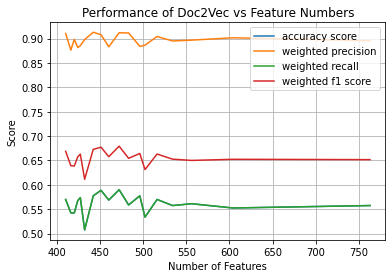

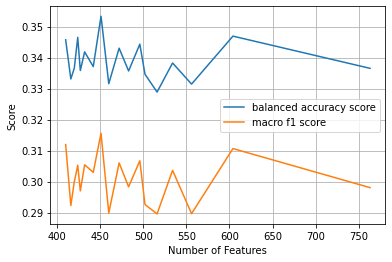

In [ ]:
eval_path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models/evaluation_rf_d2v.csv'
plot_feature_graph(model_name='Doc2Vec', eval_path=eval_path, reverse_rows=True)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 28.0 MB/s 
     |████████████████████████████████| 6.6 MB 62.5 MB/s 
     |████████████████████████████████| 120 kB 76.1 MB/s 


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
text = atis_train['message'][0]
text = '[CLS] ' + text + ' [SEP]'

tokenized_text = tokenizer.tokenize(text)

In [ ]:
tokenized_text

['[CLS]',
 'want',
 'fly',
 'boston',
 '83',
 '##8',
 'arrive',
 'denver',
 '111',
 '##0',
 'morning',
 '[SEP]']

In [ ]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
with torch.no_grad():
  outputs = model(tokens_tensor, segments_tensors)
  hidden_states = outputs[2]

NameError: ignored

In [ ]:
len(hidden_states)

13

In [ ]:
# why -2?
sent_ebd = torch.mean(hidden_states[-2][0], dim=0)

In [ ]:
sent_ebd.shape

torch.Size([768])

In [ ]:
sent_ebd.numpy()

In [ ]:
# question about features
# for bert: number of dimension of embedding?
# for word2vec, doc2vec: number of words in vocabulary?

In [ ]:
# reference: https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca

In [ ]:
def bert_rf():
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  model_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
  model_bert.eval() 

  bert_ebd_len = 768
  num_features = 768
  x_train_bert = np.zeros([len(atis_train['message']), bert_ebd_len]) # initialize to zero, save zero padding
  x_test_bert = np.zeros([len(atis_test['message']), bert_ebd_len])

  for i in range(len(atis_train['message'])):
    curr_text = atis_train['message'][i]
    curr_text = '[CLS] ' + curr_text + ' [SEP]'

    tokenized_text = tokenizer.tokenize(curr_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model_bert(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

    sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
    x_train_bert[i] = sent_ebd.numpy()

  y_train_bert = y_train
  print('training set bert encoding done')

  for i in range(len(atis_test['message'])):
    curr_text = atis_test['message'][i]
    curr_text = '[CLS] ' + curr_text + ' [SEP]'

    tokenized_text = tokenizer.tokenize(curr_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    with torch.no_grad():
      outputs = model_bert(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

    sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
    x_test_bert[i] = sent_ebd.numpy()

  y_test_bert = y_test
  print('test set bert encoding done')

  model_rf_bert = RandomForestClassifier(n_estimators=150, max_depth=None)
  model_rf_bert.fit(x_train_bert, y_train_bert)

  evaluate_model(model=model_rf_bert, name='random_forest_d2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_test_bert, y_test=y_test_bert, num_features=num_features,
                  path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_bert.csv')

In [ ]:
bert_rf()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training set bert encoding done
test set bert encoding done


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


evaluate the model:  random_forest_d2v_features_768_n_estimators=150_max_depth=None
accuracy score:  0.00375
balanced accuracy score:  0.125
weighted precision:  1.40625e-05
weighted recall:  0.00375
weighted f1 score:  2.8019925280199252e-05
macro f1 score:  0.0009339975093399751


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model_bert.eval() 

bert_ebd_len = 768
num_features = 768
x_train_bert = np.zeros([len(atis_train['message']), bert_ebd_len]) # initialize to zero, save zero padding
x_test_bert = np.zeros([len(atis_test['message']), bert_ebd_len])

# for i in range(len(atis_train['message'])):
#   curr_text = atis_train['message'][i]
#   curr_text = '[CLS] ' + curr_text + ' [SEP]'

#   tokenized_text = tokenizer.tokenize(curr_text)

#   indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#   segments_ids = [1] * len(tokenized_text)

#   tokens_tensor = torch.tensor([indexed_tokens])
#   segments_tensors = torch.tensor([segments_ids])

#   with torch.no_grad():
#     outputs = model_bert(tokens_tensor, segments_tensors)
#     hidden_states = outputs[2]

#   sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
#   x_train_bert[i] = sent_ebd.numpy()

# y_train_bert = y_train
# print('training set bert encoding done')

for i in range(len(atis_test['message'])):
  curr_text = atis_test['message'][i]
  curr_text = '[CLS] ' + curr_text + ' [SEP]'

  tokenized_text = tokenizer.tokenize(curr_text)

  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)

  with torch.no_grad():
    outputs = model_bert(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

  sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
  x_test_bert[i] = sent_ebd.numpy()

y_test_bert = y_test
print('test set bert encoding done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test set bert encoding done


In [ ]:
model_rf_bert = RandomForestClassifier(n_estimators=150, max_depth=None)
model_rf_bert.fit(x_test_bert, y_test_bert)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


RandomForestClassifier(n_estimators=150)

In [ ]:
evaluate_model(model=model_rf_bert, name='random_forest_d2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_test_bert, y_test=y_test_bert, num_features=num_features,
                path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_bert_test.csv')

evaluate the model:  random_forest_d2v_features_768_n_estimators=150_max_depth=None
accuracy score:  0.79
balanced accuracy score:  0.125
weighted precision:  0.6241
weighted recall:  0.79
weighted f1 score:  0.6973184357541901
macro f1 score:  0.11033519553072627


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model_bert.eval() 

bert_ebd_len = 768
num_features = 768
x_train_bert = np.zeros([len(atis_train['message']), bert_ebd_len]) # initialize to zero, save zero padding
x_test_bert = np.zeros([len(atis_test['message']), bert_ebd_len])

for i in range(len(atis_train['message'])):
  curr_text = atis_train['message'][i]
  curr_text = '[CLS] ' + curr_text + ' [SEP]'

  tokenized_text = tokenizer.tokenize(curr_text)

  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)

  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  with torch.no_grad():
    outputs = model_bert(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

  sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
  x_train_bert[i] = sent_ebd.numpy()

y_train_bert = y_train
print('training set bert encoding done')

# for i in range(len(atis_test['message'])):
#   curr_text = atis_test['message'][i]
#   curr_text = '[CLS] ' + curr_text + ' [SEP]'

#   tokenized_text = tokenizer.tokenize(curr_text)

#   indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#   segments_ids = [1] * len(tokenized_text)

#   with torch.no_grad():
#     outputs = model_bert(tokens_tensor, segments_tensors)
#     hidden_states = outputs[2]

#   sent_ebd = torch.mean(hidden_states[-2][0], dim=0)
#   x_test_bert[i] = sent_ebd.numpy()

# y_test_bert = y_test
# print('test set bert encoding done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training set bert encoding done


In [ ]:
model_rf_bert = RandomForestClassifier(n_estimators=150, max_depth=None)
model_rf_bert.fit(x_train_bert, y_train_bert)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


RandomForestClassifier(n_estimators=150)

In [ ]:
evaluate_model(model=model_rf_bert, name='random_forest_d2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_train_bert, y_test=y_train_bert, num_features=num_features,
                path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_bert_train.csv')

evaluate the model:  random_forest_d2v_features_768_n_estimators=150_max_depth=None
accuracy score:  1.0
balanced accuracy score:  1.0
weighted precision:  1.0
weighted recall:  1.0
weighted f1 score:  1.0
macro f1 score:  1.0


In [ ]:
evaluate_model(model=model_rf_bert, name='random_forest_d2v_features_{}_n_estimators=150_max_depth=None'.format(num_features), x_test=x_test_bert, y_test=y_test_bert, num_features=num_features,
                path='/content/drive/MyDrive/nlp_datasets/ATIS dataset/models', filename='evaluation_rf_bert.csv')

evaluate the model:  random_forest_d2v_features_768_n_estimators=150_max_depth=None
accuracy score:  0.04125
balanced accuracy score:  0.125
weighted precision:  0.0017015625000000002
weighted recall:  0.04125
weighted f1 score:  0.003268307322929172
macro f1 score:  0.009903961584633855


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  
